In [150]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import pickle 
import numpy as np

# Load the scaler and the model from the pickle files
scaler_file = 'scaler.pkl'
model_file = 'model_randomforest_14.pkl'

with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)

with open(model_file, 'rb') as file:
    model = pickle.load(file)

scaler, model



(StandardScaler(), RandomForestRegressor(n_estimators=14, random_state=41))

In [151]:
# Corrected function to calculate rainfall for the previous 2 hours for each record
def calculate_rainfall_previous_2_hours_corrected(df):
    # Set the index to the time for rolling window calculations
    df = df.set_index('time')
    
    #for loop 
    for i in range(0, len(df)):
        #get the rainfall of 8 records before the current record before the current record, if out of range, set to 0  
        if i < 8:
            df.loc[df.index[i], 'rainfall_previous_2_hours'] = 0
        else:
            df.loc[df.index[i], 'rainfall_previous_2_hours'] = df.loc[df.index[i-8], 'precipitation']
        
    #reset the index
    df = df.reset_index()
    
    return df

In [152]:
#drop the first day of the df (yessterday's data)
def drop_first_day(df):
    df = df[96:]
    return df

In [153]:
def init_lag_features(df, model, scaler):
    # Initialize the lag features with default values
    default_value = 0  # Replace with a sensible default if applicable
    df['percentage_previous_1'] = default_value
    df['percentage_previous_2'] = default_value
    df['percentage_previous_3'] = default_value
    df['percentage_previous_4'] = default_value
    df['percentage_previous_5'] = default_value
    df['percentage_previous_6'] = default_value

    # Iterate through the DataFrame and predict the percentage for each record
    for index, row in df.iterrows():
        # Scale the entire row
        scaled_row = scaler.transform([row.values])

        # Predict using the model
        predicted_percentage = model.predict(scaled_row)[0]
        
        # Update the lag features for the next record
        if index + 1 < len(df):
            df.loc[index + 1, 'percentage_previous_1'] = predicted_percentage
            if index + 1 >= 2:
                df.loc[index + 1, 'percentage_previous_2'] = df.loc[index, 'percentage_previous_1']
            if index + 1 >= 3:
                df.loc[index + 1, 'percentage_previous_3'] = df.loc[index, 'percentage_previous_2']
            if index + 1 >= 4:
                df.loc[index + 1, 'percentage_previous_4'] = df.loc[index, 'percentage_previous_3']
            if index + 1 >= 5:
                df.loc[index + 1, 'percentage_previous_5'] = df.loc[index, 'percentage_previous_4']
            if index + 1 >= 6:
                df.loc[index + 1, 'percentage_previous_6'] = df.loc[index, 'percentage_previous_5']

    return df

            
            


In [154]:
# Fetch data from the API
url = 'https://api.open-meteo.com/v1/forecast?latitude=51.55202&longitude=4.586668&minutely_15=precipitation&past_days=1&forecast_days=3'
response = requests.get(url)
data = response.json() if response.status_code == 200 else {}

# Fetch data from the API
url_daily_sum = 'https://api.open-meteo.com/v1/forecast?latitude=51.55202&longitude=4.586668&daily=precipitation_sum&timezone=Europe%2FBerlin'
response_daily_sum = requests.get(url_daily_sum)
data_daily_sum = response_daily_sum.json() if response_daily_sum.status_code == 200 else {}

# Prepare the DataFrame from API data
if data and data_daily_sum:
    # Extract minutely_15 data
    minutely_data = data['minutely_15']
    
    # Create DataFrame from the extracted data
    df = pd.DataFrame({
        'time': pd.to_datetime(minutely_data['time']),
        'precipitation': minutely_data['precipitation']
    })

    # Add columns for 'day', 'month', 'dayofweek', 'hour', 'rainfall_current'
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['dayofweek'] = df['time'].dt.dayofweek
    df['hour'] = df['time'].dt.hour
    df['rainfall_current'] = df['precipitation']

    # Calculate rainfall for 2 hours ago
    df = calculate_rainfall_previous_2_hours_corrected(df)
    df = drop_first_day(df)

    df_og = df.copy()
    
    #drop time
    df = df.drop(columns=['time'])
    df = df.drop(columns=['precipitation'])

    # Initialize the lag features
    df = init_lag_features(df, model, scaler)

    # Extract the relevant data
    dates = data_daily_sum['daily']['time']
    precipitation_sum = data_daily_sum['daily']['precipitation_sum']

else:
    print("Failed to retrieve or process API data")


c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid f

In [155]:
df 

,day,month,dayofweek,hour,rainfall_current,rainfall_previous_2_hours,percentage_previous_1,percentage_previous_2,percentage_previous_3,percentage_previous_4,percentage_previous_5,percentage_previous_6
96,20,12,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,20,12,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,20,12,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,20,12,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,20,12,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
379,22,12,4,22,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0
380,22,12,4,23,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0
381,22,12,4,23,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0
382,22,12,4,23,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
results = model.predict(df)


c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [157]:
results

array([ 8.8005    ,  8.8005    ,  8.8005    ,  8.8005    ,  8.88885714,
        8.88885714,  8.88885714,  8.88885714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91

In [158]:
import matplotlib.pyplot as plt

def plot_predictions_and_rainfall(pred_df, results, model_name):
    # plot the predictions in a line chart, put the percentage and rainfull_current against each other
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('time')
    ax1.set_ylabel('Rainfall (mm)')
    ax1.plot(pred_df['time'], pred_df['rainfall_current'], color='blue')
    ax1.plot(pred_df['time'], pred_df['rainfall_current'], color='blue', linestyle='dashed')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Percentage (%)')
    ax2.plot(pred_df['time'], results, color='red')
    ax2.plot(pred_df['time'], results, color='red', linestyle='dashed')
    ax2.tick_params(axis='y')

    fig.legend(['Rainfall', 'Rainfall pre', 'Percentage', 'Percentage pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Rainfall and percentage full over time - {model_name}')
    plt.show()

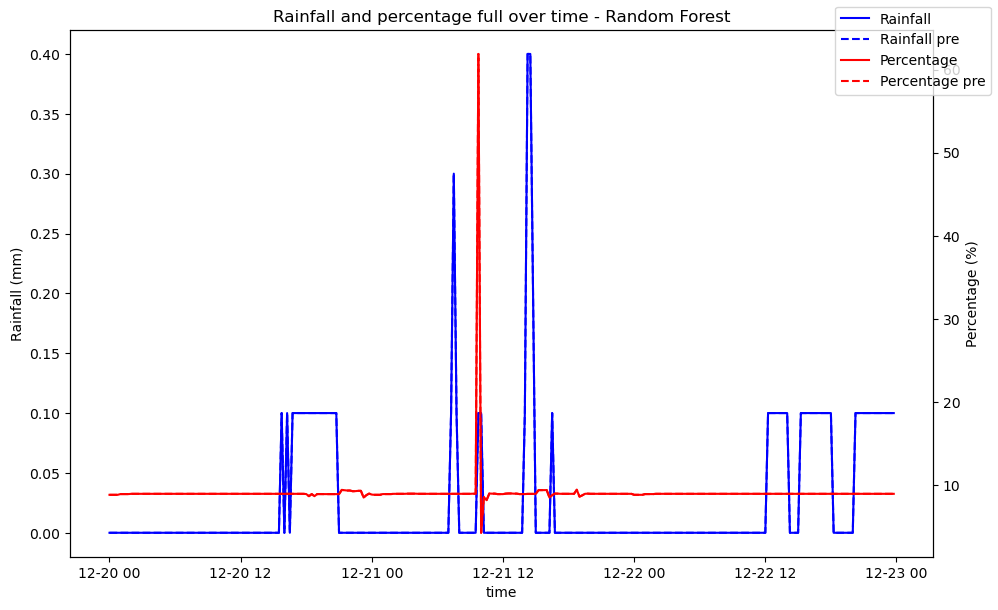

In [159]:
plot_predictions_and_rainfall(df_og, results, 'Random Forest')

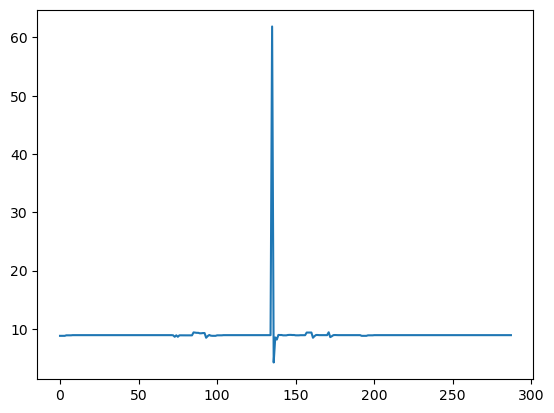

In [160]:
#plot results
import matplotlib.pyplot as plt
plt.plot(results)
plt.show()